In [130]:
import torch
import torchvision

import matplotlib.pyplot as plt
from torch import nn

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

from collections.abc import Callable


In [131]:
torch.manual_seed(23)
torch.cuda.manual_seed(23)


In [132]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [133]:
train_data = datasets.FashionMNIST(
	root='datasets/',
	train=True,
	download=False,
	transform=transforms.ToTensor(),
	target_transform=None
)

test_data = datasets.FashionMNIST(
	root='datasets/',
	train=False,
	download=False,
	transform=transforms.ToTensor(),
	target_transform=None
)


BATCH_SIZE = 32

train_dl = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


In [134]:
class CNN_Model(nn.Module):
	def __init__(self, in_channel, hidden_num, out_shape, image_height, image_width):
		super().__init__()

		self.conv_block_1 = nn.Sequential(
			nn.Conv2d(
				in_channels=in_channel,
				out_channels=hidden_num,
				kernel_size=3,
				stride=1,
				padding=1
			),
			nn.ReLU(),
			nn.Conv2d(
				in_channels=hidden_num,
				out_channels=hidden_num,
				kernel_size=3,
				stride=1,
				padding=1
			),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2)
		)

		self.conv_block_2 = nn.Sequential(
			nn.Conv2d(
				in_channels=hidden_num,
				out_channels=hidden_num,
				kernel_size=3,
				stride=1,
				padding=1
			),
			nn.ReLU(),
			nn.Conv2d(
				in_channels=hidden_num,
				out_channels=hidden_num,
				kernel_size=3,
				stride=1,
				padding=1
			),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2)
		)

		with torch.inference_mode():
			shape: tuple = nn.Sequential(
				self.conv_block_1,
				self.conv_block_2
			)(torch.zeros(size=(1, in_channel, image_height, image_width))).shape

		classifier_in_size = (shape[1] * shape[2] * shape[3])

		self.classifier = nn.Sequential(
			nn.Flatten(),
			nn.Linear(
				in_features=classifier_in_size,
			 	out_features=out_shape
			)
		)

		self.layer_stack = nn.Sequential(
			self.conv_block_1,
			self.conv_block_2,
			self.classifier
		)

	def forward(self, X: torch.Tensor) -> torch.Tensor:
		return self.layer_stack(X)

model = CNN_Model(
	in_channel=1,
	hidden_num=10,
	out_shape=10,
	image_height=28,
	image_width=28
).to(device)


In [135]:
from torch.utils.data import DataLoader

def train_step(
		model: nn.Module,
		dataloader: DataLoader,
		loss_fn: Callable,
		optimizer,
		device: 'str'
) -> float:
	"""
	This function will do one step of the training, based on the given dataloader
	"""
	loss: float = 0

	# go to train mode
	model.train()

	for (sample, label) in dataloader:
		sample, label = sample.to(device), label.to(device)

		pred = model(sample)

		loss_batch = loss_fn(pred, label)
		loss += loss_batch

		optimizer.zero_grad()

		loss_batch.backward()

		optimizer.step()

	loss /= len(dataloader)

	return loss

def test_step(
		model: nn.Module,
		dataloader: DataLoader,
		loss_fn: Callable,
		device: 'str'
) -> tuple[float, float]:
	model.eval()
	with torch.inference_mode():
		loss: float = 0
		accuracy: float = 0

		for (sample, label) in dataloader:
			sample, label = sample.to(device), label.to(device)
			pred = model(sample)

			loss_batch = loss_fn(pred, label)
			loss += loss_batch

			accuracy += accuracy_score(y_true=label.cpu(), y_pred=pred.argmax(dim=1).cpu()) # type: ignore

		loss /= len(dataloader)
		accuracy /= len(dataloader)

	return loss, accuracy


In [137]:
# with functions

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-2) # type: ignore

epochs = 20

for epoch in range(1, epochs+1):
	loss = train_step(model, train_dl, loss_fn, optimizer, device)

	test_loss, acc = test_step(model, test_dl, loss_fn, device)
	acc *= 100
	print(
		f'{epoch=}: {loss=:.3f} | {test_loss=:.3f} | {acc=:.2f}%'
	) if epoch == 1 or epoch % 5 == 0 else ...


epoch=1: loss=0.290 | test_loss=0.330 | acc=88.12%
epoch=5: loss=0.271 | test_loss=0.305 | acc=89.16%
epoch=10: loss=0.255 | test_loss=0.301 | acc=89.25%
epoch=15: loss=0.243 | test_loss=0.293 | acc=89.52%


KeyboardInterrupt: 

In [196]:
import random

row, col = 4, 4

test_sample = []
test_label = []
for sample, label in random.sample(list(test_data), k=row*col):
	test_sample.append(sample)
	test_label.append(label)


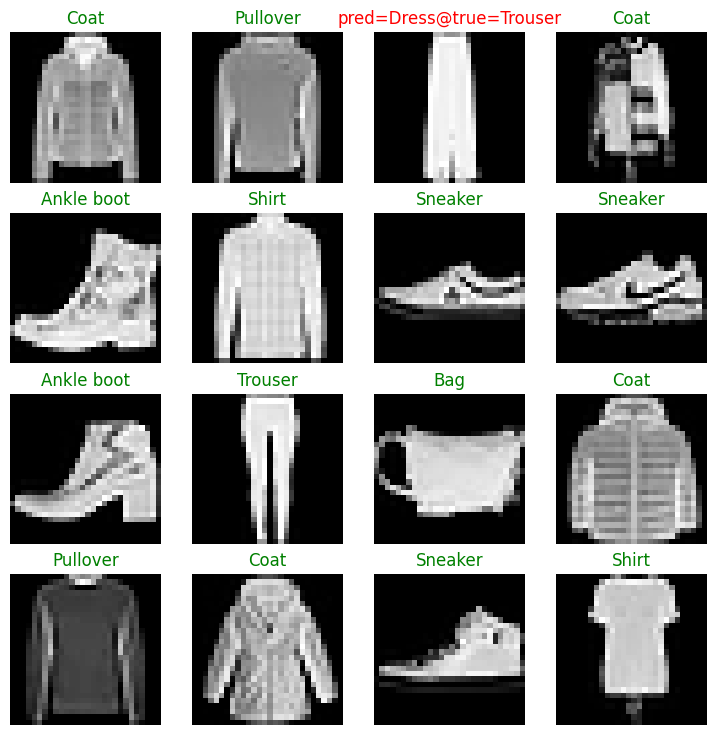

In [197]:
plt.figure(figsize=(9,9))
for i in range(row*col):
	sample = test_sample[i].squeeze().to(device)
	plt.subplot(row, col, i+1)
	plt.axis(False)
	plt.imshow(sample.cpu(), cmap='gray')

	pred = model(sample.reshape((1,1,28,28))).argmax(dim=1)
	if pred == test_label[i]:
		plt.title(test_data.classes[pred], color='g')
	else:
		plt.title(
			f'pred={test_data.classes[pred]}@true={test_data.classes[test_label[i]]}',
			color='r'
		)
